In [1]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

# SIR model

In [2]:
# define functions ϕ of flows in the SIR model
fNewIncidence(u,p,t)=p.cβ*u.S*u.I/p.N
fNewRecovery(u,p,t)=u.I/p.tr

# StockAndFlowp(stocks,
#               (flow=>function, upstream=>downstream) => stocks linked)
sir = StockAndFlowp((:S, :I, :R), 
   ((:NewIncidence=>fNewIncidence, :S=>:I)=>(:S,:I),
    (:NewRecovery=>fNewRecovery, :I=>:R)=>:I)
)

StockAndFlowp with elements Flow = 1:2, Stock = 1:3, Link = 1:3
┌──────┬───┬───┬──────────────┬───────────────┐
│ Flow │ u │ d │        fname │            ϕf │
├──────┼───┼───┼──────────────┼───────────────┤
│    1 │ 1 │ 2 │ NewIncidence │ fNewIncidence │
│    2 │ 2 │ 3 │  NewRecovery │  fNewRecovery │
└──────┴───┴───┴──────────────┴───────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     I │
│     3 │     R │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 1 │
│    3 │ 2 │ 2 │
└──────┴───┴───┘

#### Now, we just created a Stock and Flow Diagram of a SIR model with the primitive schema. We can plot the Stock and Flow Diagram:

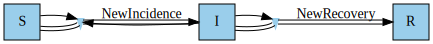

In [3]:
Graph(sir)

#### We can run the ODEs generated from this Stock and Flow Diagram directly:
To run the model, we need to define 

In [4]:
# define constant parameters
p_sir = LVector(
    cβ=0.2, N=1000, tr=12
)
# define initial values for stocks
u0_sir = LVector(
    S=990, I=10, R=0
)

3-element LArray{Int64, 1, Vector{Int64}, (:S, :I, :R)}:
 :S => 990
 :I => 10
 :R => 0

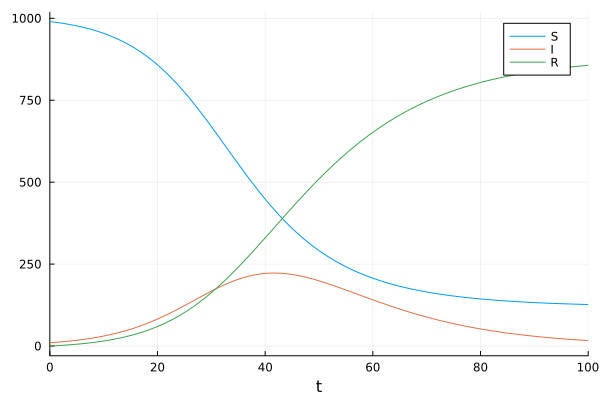

In [5]:
# solve the ODEs
prob_sir = ODEProblem(vectorfield(sir),u0_sir,(0.0,100.0),p_sir);
sol_sir = solve(prob_sir,Tsit5(),abstol=1e-8);
plot(sol_sir)

# Create SIRV model by composition

If we would like to considering vaccination process. And suppose the vaccination could not fully protect vaccinated individuals, there is a flow from stock "V" to "I", which indicates the vaccinated persons still have a chance to be infected.
We can create the Stock and Flow Diagram only represents the vaccination and vaccinated individuals infection process, which we name it SVI model. And the final SIRV model can be generated simply by composing SIR model and SVI model via the common parts: stocks "S" and "I".

## Model B: SVI model

In [6]:
# define functions ϕ of flows in the SVI model
fNewIncidenceFromV(u,p,t)=p.cβ*u.V*u.I*(1-p.e)/p.N
fNewVaccinated(u,p,t)=u.S*p.rv

# StockAndFlowp(stocks,
#               (flow=>function, upstream=>downstream) => stocks linked)
svi = StockAndFlowp((:S, :V, :I), 
   ((:NewIncidenceFromV=>fNewIncidenceFromV, :V=>:I)=>(:V,:I),
    (:NewVaccinated=>fNewVaccinated, :S=>:V)=>:S)
)

StockAndFlowp with elements Flow = 1:2, Stock = 1:3, Link = 1:3
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 2 │ 3 │ NewIncidenceFromV │ fNewIncidenceFromV │
│    2 │ 1 │ 2 │     NewVaccinated │     fNewVaccinated │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     V │
│     3 │     I │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 2 │ 1 │
│    2 │ 3 │ 1 │
│    3 │ 1 │ 2 │
└──────┴───┴───┘

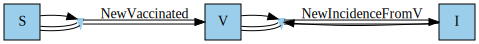

In [7]:
Graph(svi)

## Composition method 1 -- via strucutured cospan

### Open SIR stock and flow Diagram as a structured cospan, with the left foot [:R], and with the right foot [:S, :I]

In [8]:
open_sir=Open([:R],sir,[:S,:I]);

### Open SVI stock and flow Diagram as a structured cospan, with the left foot [:S,:I], and with the right foot [:V]

In [9]:
open_svi=Open([:S,:I],svi,[:V]);

### Now, we can compose those two structured cospan with the commom foot [:S,:I]. And the composed model is the SIRV model we need

In [10]:
sirv1=apex(compose(open_sir,open_svi))

StockAndFlowp with elements Flow = 1:4, Stock = 1:4, Link = 1:6
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 1 │ 2 │      NewIncidence │      fNewIncidence │
│    2 │ 2 │ 3 │       NewRecovery │       fNewRecovery │
│    3 │ 4 │ 2 │ NewIncidenceFromV │ fNewIncidenceFromV │
│    4 │ 1 │ 4 │     NewVaccinated │     fNewVaccinated │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     I │
│     3 │     R │
│     4 │     V │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 1 │
│    3 │ 2 │ 2 │
│    4 │ 4 │ 3 │
│    5 │ 2 │ 3 │
│    6 │ 1 │ 4 │
└──────┴───┴───┘

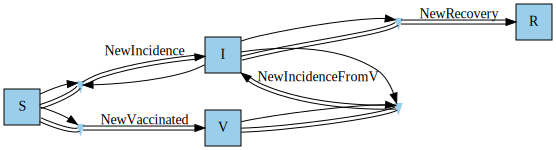

In [11]:
Graph(sirv1)

## Composition method 2 -- via uwd-algebra

### Define the composition rule of the uwd-algebra

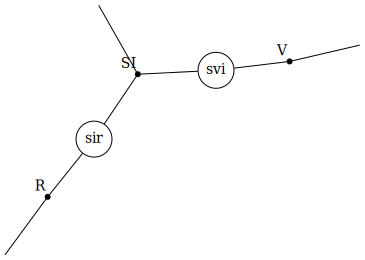

In [18]:
uwd_sirv = @relation (R, SI, V) begin
    sir(R,SI)
    svi(SI,V)
end;
display_uwd(uwd_sirv)

In [20]:
sirv2=oapply(uwd_sirv,Dict(
        :sir=>Open(sir,[:R],[:S,:I]),
        :svi=>Open(svi,[:S,:I],[:V]))) |> apex

StockAndFlowp with elements Flow = 1:4, Stock = 1:4, Link = 1:6
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 1 │ 2 │      NewIncidence │      fNewIncidence │
│    2 │ 2 │ 3 │       NewRecovery │       fNewRecovery │
│    3 │ 4 │ 2 │ NewIncidenceFromV │ fNewIncidenceFromV │
│    4 │ 1 │ 4 │     NewVaccinated │     fNewVaccinated │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     I │
│     3 │     R │
│     4 │     V │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 1 │
│    3 │ 2 │ 2 │
│    4 │ 4 │ 3 │
│    5 │ 2 │ 3 │
│    6 │ 1 │ 4 │
└──────┴───┴───┘

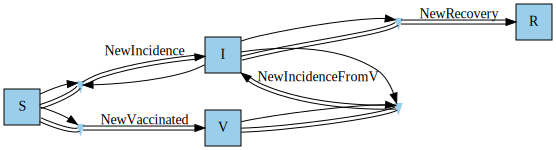

In [21]:
Graph(sirv2)

# Solve the SIRV model

Define constant parameters and initial values

In [22]:
p_sirv = LVector(
    cβ=0.2, N=1000, tr=12, rv=0.02, e=0.9
)
# define initial values for stocks
u0_sirv = LVector(
    S=990, I=10, R=0, V=0
)

4-element LArray{Int64, 1, Vector{Int64}, (:S, :I, :R, :V)}:
 :S => 990
 :I => 10
 :R => 0
 :V => 0

## Model results of sirv1 generated by the method of composing the structured cospan

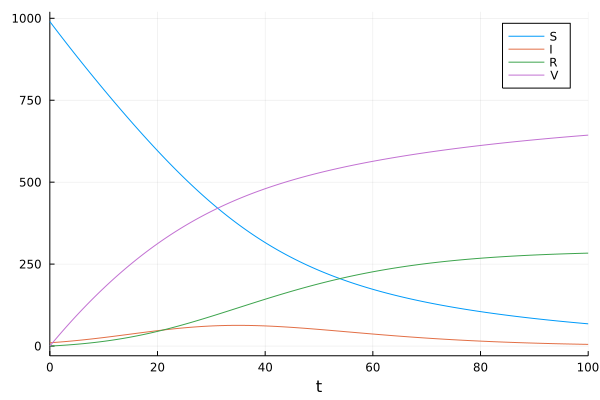

In [23]:
prob_sirv1 = ODEProblem(vectorfield(sirv1),u0_sirv,(0.0,100.0),p_sirv);
sol_sirv1 = solve(prob_sirv1,Tsit5(),abstol=1e-8);
plot(sol_sirv1)

## Model results of sirv2 generated by the method of composing using uwd-algebra

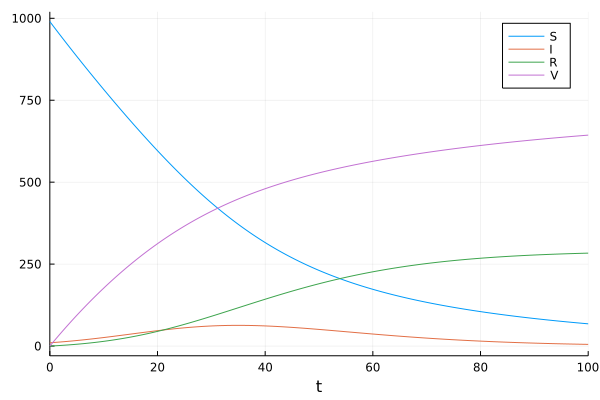

In [24]:
prob_sirv2 = ODEProblem(vectorfield(sirv2),u0_sirv,(0,100.0),p_sirv)
sol_sirv2 = solve(prob_sirv2,Tsit5(),sbstol=1e-8);
plot(sol_sirv2)